In [17]:
import pandas as pd
import numpy as np
import json
import os
import operator
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import evaluate_queries as evaluate_queries

import utils

from pathlib import Path

from sklearn.metrics import ndcg_score
from tqdm import tqdm

sns.set(rc={'figure.figsize':(24, 14)}, font_scale=2)
sns.set_style("whitegrid")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Functions

In [49]:
def update_df(df, scores_path):
    '''
    Given a wikipages queries dataframe `df` and its respective NDCG `scores_path`
    update df to map the NDCG scores @k for each wikipage
    '''
    for file in os.listdir(scores_path):
        with open(scores_path + file, 'r') as f:
            scores_dict = json.load(f)
        wikipage_id_to_score = {}
        for wikipage_id in scores_dict:
            wikipage_id_to_score[int(wikipage_id)] = scores_dict[wikipage_id]['ndcg']
        
        k = file.split('_')[-1].split('.')[0]
        df['ndcg@'+k] = np.nan
        df['ndcg@'+k] = df['wikipage_id'].map(wikipage_id_to_score)

    return df

def get_query_df_dict(query_df_base_dir, score_paths_base_dir, min_tuple_width, mode, tuples_per_query_list):
    # Dictionary keyed by the number of tuples per query to the query dataframe that contains the NDCG scores at various k values
    query_df_dict = {}

    for tuples_per_query in tuples_per_query_list:
        df = pd.read_pickle(query_df_base_dir+'minTupleWidth_2_tuplesPerQuery_'+str(tuples_per_query)+'.pickle')  
        scores_path = score_paths_base_dir + 'minTupleWidth_' + str(min_tuple_width) + '_tuplesPerQuery_' + str(tuples_per_query) + '/' + mode + '/'

        query_df_dict[tuples_per_query] = update_df(df, scores_path)
    
    return query_df_dict

def get_ndcg_scores_at_k_stats(df_dict, top_k_vals, tuples_per_query_list):
    '''
    Returns the dictionaries indexed by the tuples_per_query corresponding to the mean and standard deviation of the ndcg@k scores
    '''
    mean_ndcg_scores_at_k = {}
    std_ndcg_scores_at_k = {}
    for tuples_per_query in tuples_per_query_list:
        mean_ndcg_scores_at_k[tuples_per_query] = [df_dict[tuples_per_query]['ndcg@'+str(k)].mean() for k in top_k_vals]
        std_ndcg_scores_at_k[tuples_per_query] = [df_dict[tuples_per_query]['ndcg@'+str(k)].std() for k in top_k_vals]
    return mean_ndcg_scores_at_k, std_ndcg_scores_at_k

def get_melted_df(original_df, with_EL_links_df):
    cur_df=original_df.copy()
    cur_df['mode']='Original Links'
    tmp_df=with_EL_links_df.copy()
    with_EL_links_df['mode']='EL Links'
    cur_df=cur_df.append(tmp_df, ignore_index=True)

    cur_df_melted = pd.melt(cur_df, id_vars=['wikipage_id', 'mode'], value_vars=['ndcg@1', 'ndcg@2', 'ndcg@5', 'ndcg@10'])
    return cur_df_melted

# Wikitables 2013 EL (Small Dataset)

In [23]:
query_df_base_dir = '../../data/queries/wikipages/query_dataframes/wikitables_2013_EL_selection/filtered_queries/'
min_tuple_width=2
tuples_per_query_list=[1,2,5,10]; top_k_vals = [1,2,5,10]

In [27]:
selected_tables_jaccard_types_scores_dir='eval_over_search_output/wikitables_2013_EL_small_dataset/selected_tables/adjusted_jaccard/weighted/max_similarity_per_col/search_output/'
selected_tables_with_EL_links_jaccard_types_scores_dir='eval_over_search_output/wikitables_2013_EL_small_dataset/selected_tables_with_EL_links/adjusted_jaccard/weighted/max_similarity_per_col/search_output/'
selected_tables_embeddings_scores_dir='eval_over_search_output/wikitables_2013_EL_small_dataset/selected_tables/embeddings/norm_cos/max_similarity_per_col/search_output/'
selected_tables_with_EL_links_embeddings_scores_dir='eval_over_search_output/wikitables_2013_EL_small_dataset/selected_tables_with_EL_links/embeddings/norm_cos/max_similarity_per_col/search_output/'

jaccard_types_selected_tables_eval_df = get_query_df_dict(
    query_df_base_dir=query_df_base_dir,
    score_paths_base_dir=selected_tables_jaccard_types_scores_dir,
    min_tuple_width=min_tuple_width,
    mode = 'jaccard_categories',
    tuples_per_query_list=tuples_per_query_list
)

jaccard_types_selected_tables_with_EL_links_eval_df = get_query_df_dict(
    query_df_base_dir=query_df_base_dir,
    score_paths_base_dir=selected_tables_with_EL_links_jaccard_types_scores_dir,
    min_tuple_width=min_tuple_width,
    mode = 'jaccard_categories',
    tuples_per_query_list=tuples_per_query_list
)

embeddings_selected_tables_eval_df = get_query_df_dict(
    query_df_base_dir=query_df_base_dir,
    score_paths_base_dir=selected_tables_embeddings_scores_dir,
    min_tuple_width=min_tuple_width,
    mode = 'jaccard_categories',
    tuples_per_query_list=tuples_per_query_list
)

embeddings_selected_tables_with_EL_links_eval_df = get_query_df_dict(
    query_df_base_dir=query_df_base_dir,
    score_paths_base_dir=selected_tables_with_EL_links_embeddings_scores_dir,
    min_tuple_width=min_tuple_width,
    mode = 'jaccard_categories',
    tuples_per_query_list=tuples_per_query_list
)

jaccard_types_selected_tables_mean_scores, _ = get_ndcg_scores_at_k_stats(jaccard_types_selected_tables_eval_df, top_k_vals, tuples_per_query_list)
jaccard_types_selected_tables_with_EL_links_mean_scores, _ = get_ndcg_scores_at_k_stats(jaccard_types_selected_tables_with_EL_links_eval_df, top_k_vals, tuples_per_query_list)
embeddings_types_selected_tables_mean_scores, _ = get_ndcg_scores_at_k_stats(embeddings_selected_tables_eval_df, top_k_vals, tuples_per_query_list)
embeddings_selected_tables_with_EL_links_mean_scores, _ = get_ndcg_scores_at_k_stats(embeddings_selected_tables_with_EL_links_eval_df, top_k_vals, tuples_per_query_list)

In [28]:
print(jaccard_types_selected_tables_mean_scores)
print(jaccard_types_selected_tables_with_EL_links_mean_scores)
print(embeddings_types_selected_tables_mean_scores)
print(embeddings_selected_tables_with_EL_links_mean_scores)

{1: [1.0, 0.8673823367469964, 0.7676331306021791, 0.7214904329474267], 2: [1.0, 0.8659750041302653, 0.7681132135199475, 0.7297263605565293], 5: [1.0, 0.8638421457797636, 0.7671382456210063, 0.7295565538866933], 10: [1.0, 0.8661985312074743, 0.7670190527123834, 0.7238431699052148]}
{1: [0.344041910985661, 0.32851577473761, 0.32312191772934373, 0.2991618451378264], 2: [0.3547079162766663, 0.3450626937557497, 0.3473126993936956, 0.3183797938047701], 5: [0.4495040472290473, 0.4186948786972257, 0.4002953847417439, 0.3654386376102094], 10: [0.44895404722904725, 0.4444533782801193, 0.43510918928342013, 0.39566879209780803]}
{1: [1.0, 0.8275464685751868, 0.7486903022191604, 0.6804410747800823], 2: [1.0, 0.8334793644732208, 0.7559020096297977, 0.6855122226044454], 5: [1.0, 0.8487560744292807, 0.7746065784767594, 0.6999767286115874], 10: [1.0, 0.8324119250887716, 0.7727787947222268, 0.6989710477629627]}
{1: [0.4550638138138138, 0.4474224665723673, 0.4252290518440186, 0.39254131817625176], 2: [0.

## Line Figures

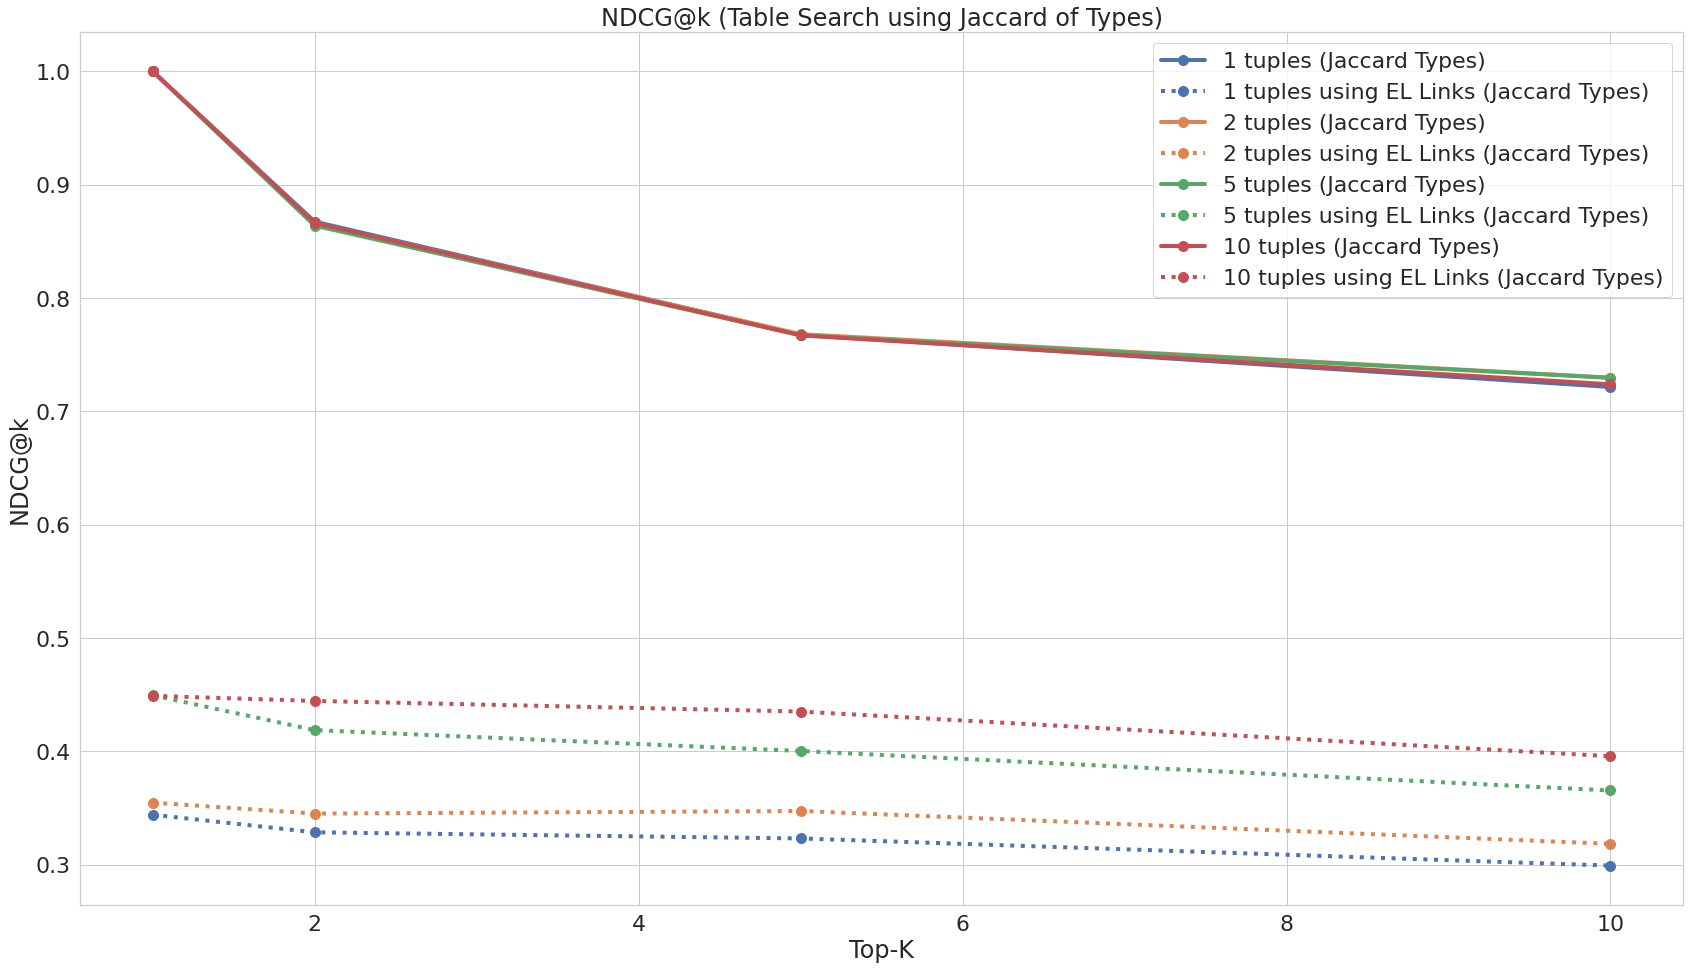

In [30]:
for i in range(len(tuples_per_query_list)):
    num_tuples=tuples_per_query_list[i]
    selected_tables_label=str(num_tuples)+' tuples' + ' (Jaccard Types)'
    selected_tables_with_EL_links_label=str(num_tuples)+' tuples using EL Links' + ' (Jaccard Types)'
    plt.plot(top_k_vals, jaccard_types_selected_tables_mean_scores[num_tuples], color=sns.color_palette()[i], linewidth=4, marker='o', markersize=10, label=selected_tables_label)
    plt.plot(top_k_vals, jaccard_types_selected_tables_with_EL_links_mean_scores[num_tuples], color=sns.color_palette()[i], linewidth=4, linestyle='dotted', marker='o', markersize=10, label=selected_tables_with_EL_links_label)

plt.ylabel('NDCG@k');plt.xlabel('Top-K');plt.title('NDCG@k (Table Search using Jaccard of Types)');plt.legend();plt.tight_layout()
plt.savefig('figures/wikitables_2013_EL_small_dataset/ndcg_at_k_vs_top_k_jaccard_types.svg')

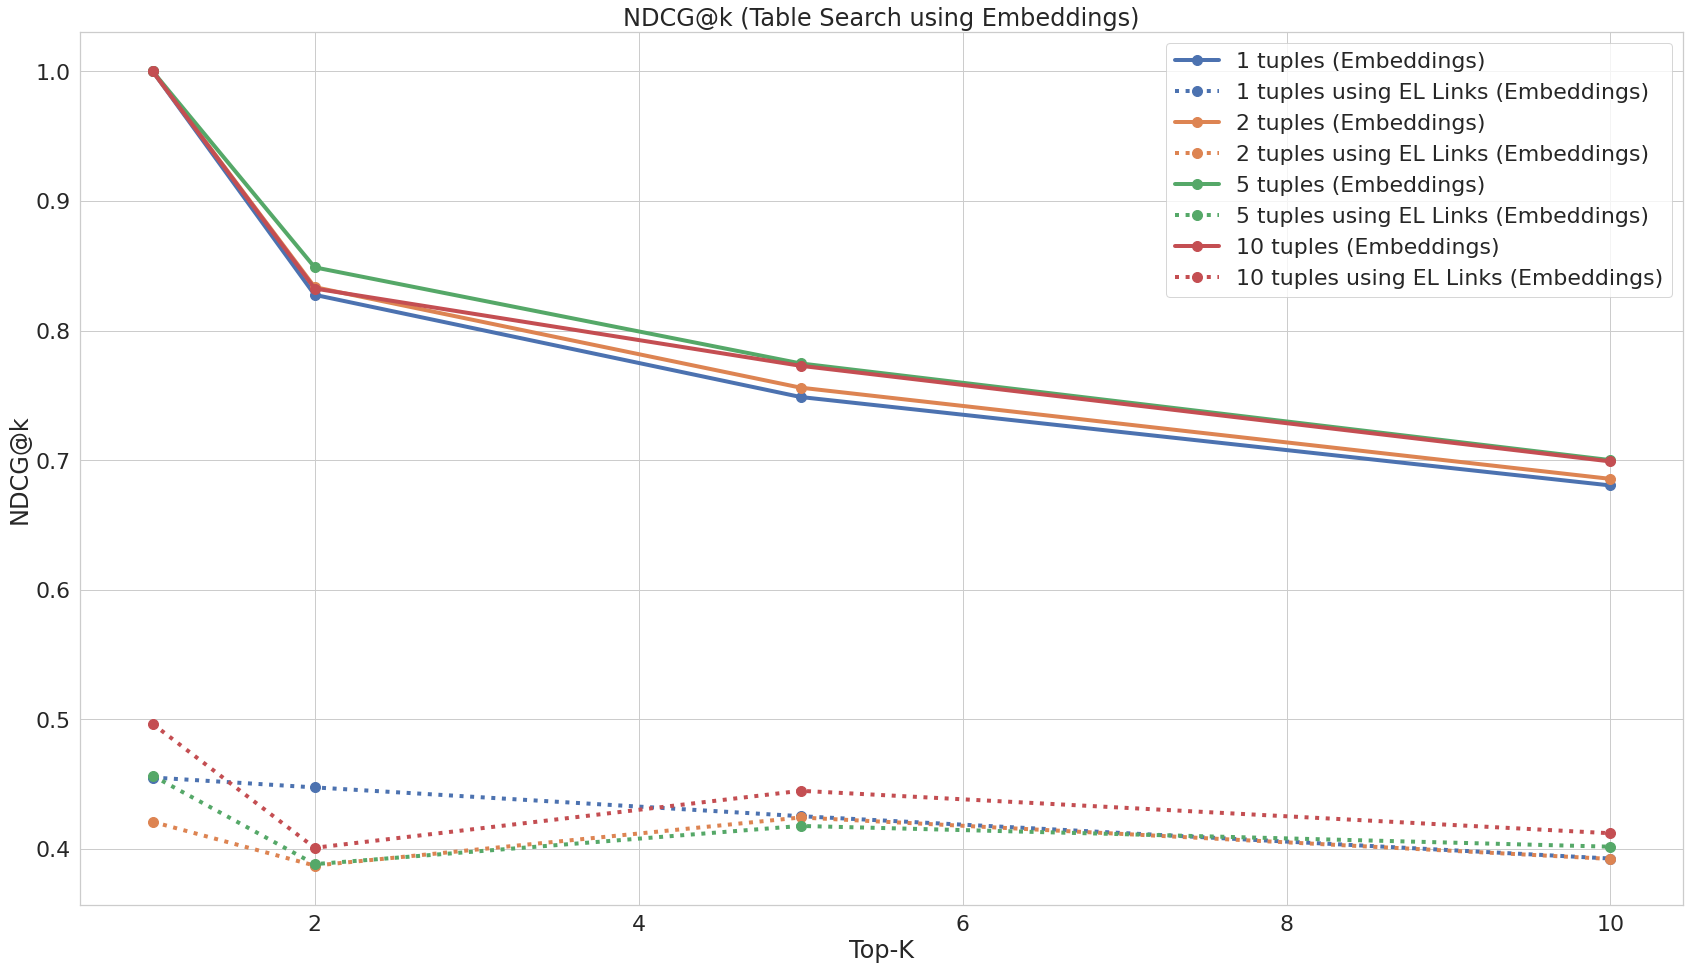

In [31]:
for i in range(len(tuples_per_query_list)):
    num_tuples=tuples_per_query_list[i]
    selected_tables_label=str(num_tuples)+' tuples' + ' (Embeddings)'
    selected_tables_with_EL_links_label=str(num_tuples)+' tuples using EL Links' + ' (Embeddings)'
    plt.plot(top_k_vals, embeddings_types_selected_tables_mean_scores[num_tuples], color=sns.color_palette()[i], linewidth=4, marker='o', markersize=10, label=selected_tables_label)
    plt.plot(top_k_vals, embeddings_selected_tables_with_EL_links_mean_scores[num_tuples], color=sns.color_palette()[i], linewidth=4, linestyle='dotted', marker='o', markersize=10, label=selected_tables_with_EL_links_label)

plt.ylabel('NDCG@k');plt.xlabel('Top-K');plt.title('NDCG@k (Table Search using Embeddings)');plt.legend();plt.tight_layout()
plt.savefig('figures/wikitables_2013_EL_small_dataset/ndcg_at_k_vs_top_k_embeddings.svg')

## Boxplot Figures

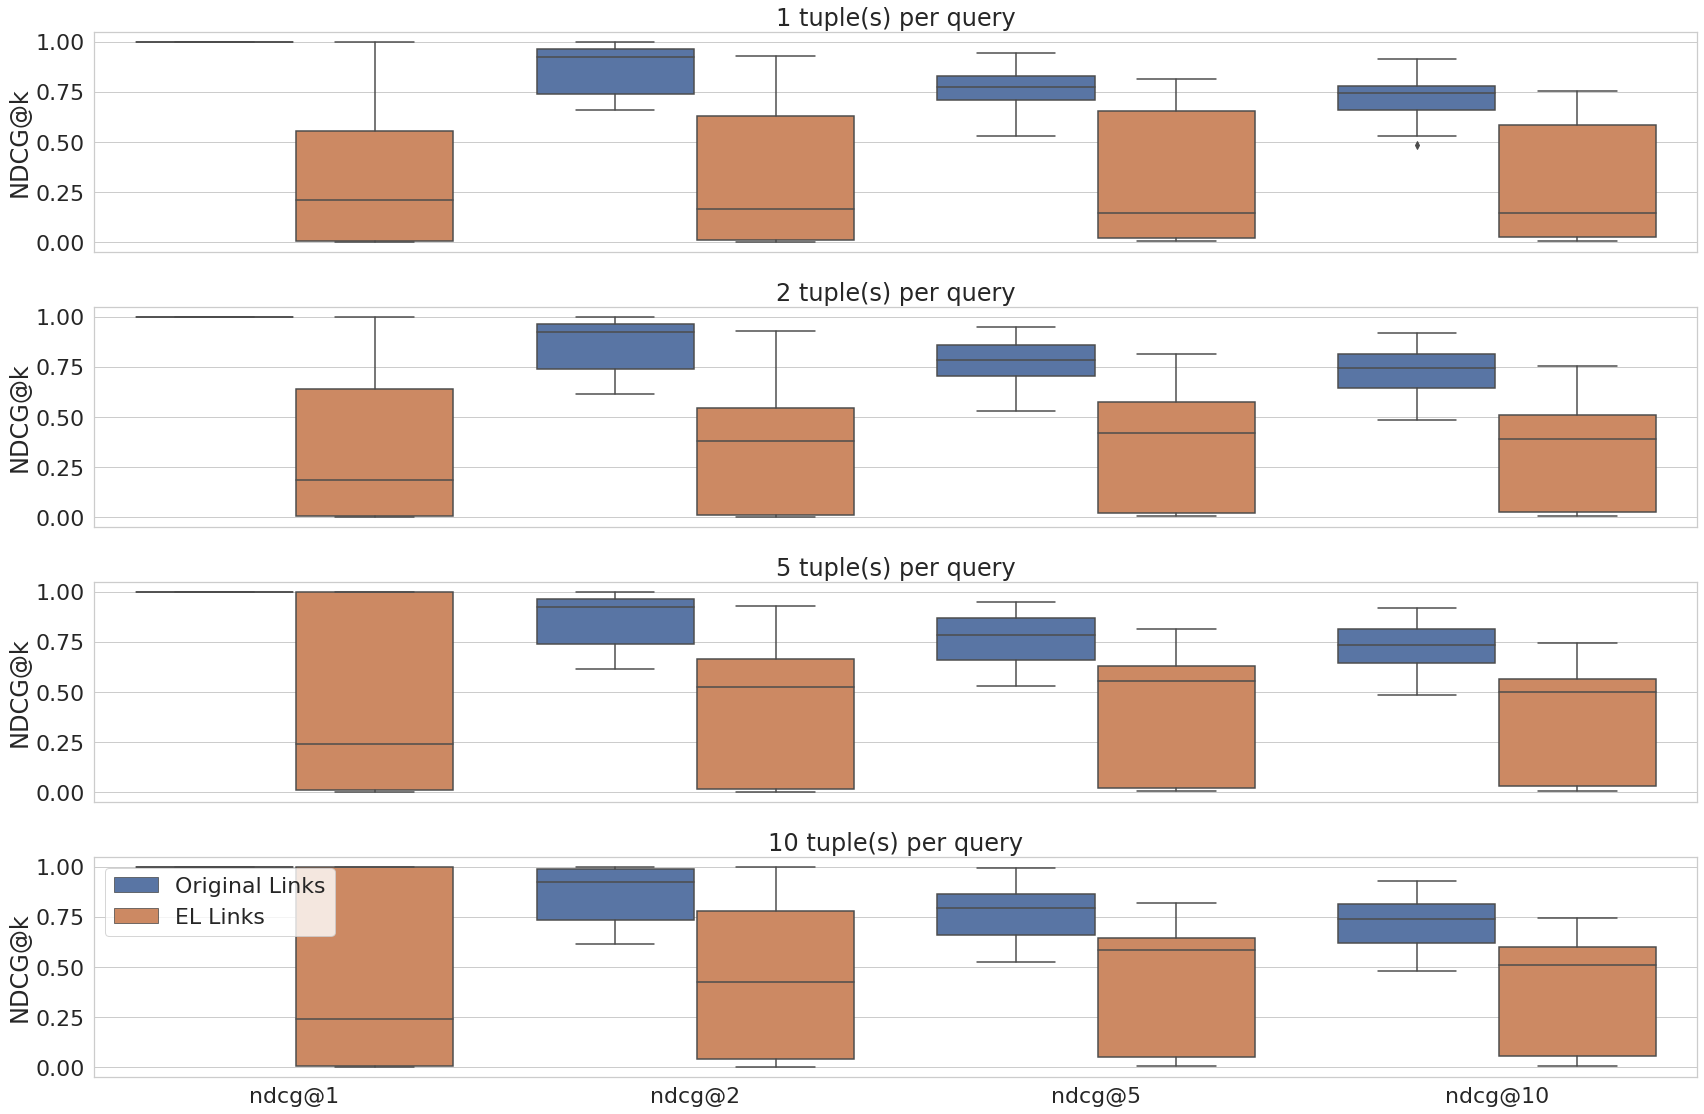

In [80]:
# Boxplot over Jaccard Types
fig, axs = plt.subplots(nrows=4, figsize=(24,16))
for i in range(len(tuples_per_query_list)):
    num_tuples=tuples_per_query_list[i]
    df=get_melted_df(jaccard_types_selected_tables_eval_df[num_tuples], jaccard_types_selected_tables_with_EL_links_eval_df[num_tuples])
    ax = sns.boxplot(data=df, x="variable", y="value", hue='mode', ax=axs[i])
    ax.set(title=str(num_tuples)+' tuple(s) per query')
    ax.set(xlabel=None);ax.set(ylabel='NDCG@k')
    axs[i].legend(title='')
    
    if i!=(len(tuples_per_query_list)-1):
        ax.get_legend().remove()
        ax.set(xticklabels=[])

plt.tight_layout();plt.savefig('figures/wikitables_2013_EL_small_dataset/boxplot_jaccard_types.svg')

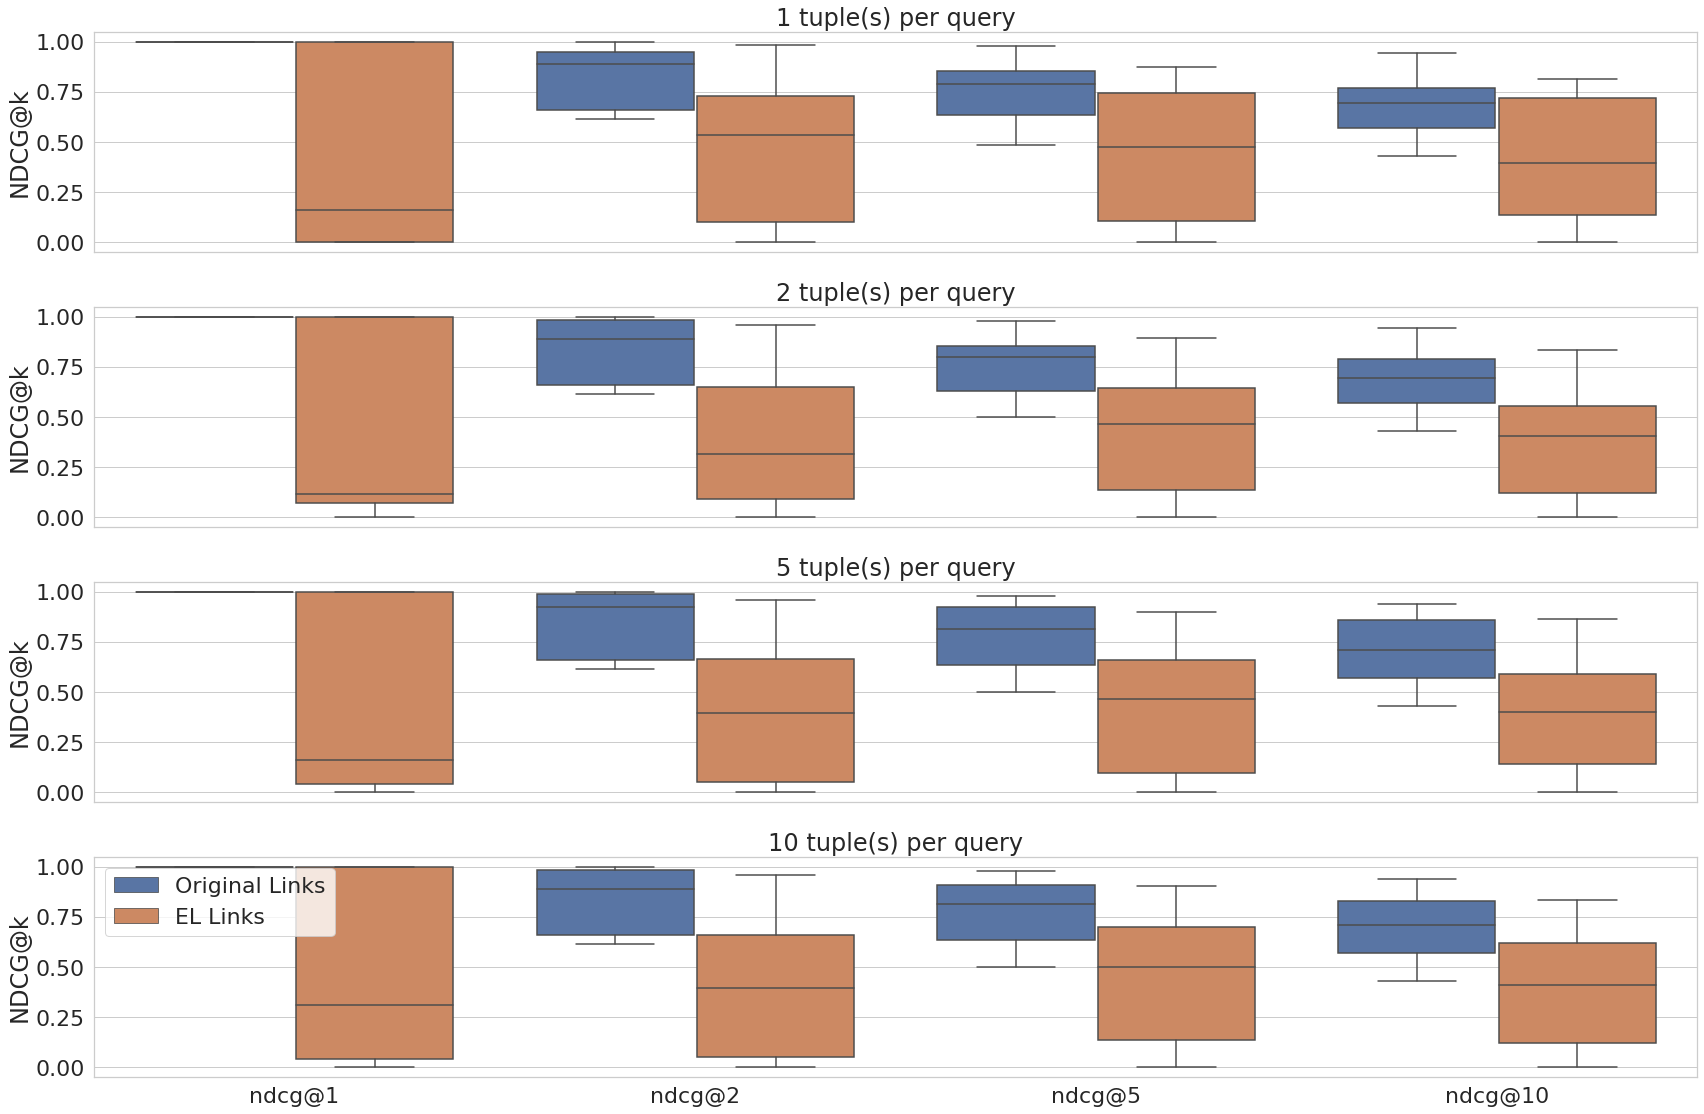

In [86]:
# Boxplot over Embeddings 
fig, axs = plt.subplots(nrows=4, figsize=(24,16))
for i in range(len(tuples_per_query_list)):
    num_tuples=tuples_per_query_list[i]
    df=get_melted_df(embeddings_selected_tables_eval_df[num_tuples], embeddings_selected_tables_with_EL_links_eval_df[num_tuples])
    ax = sns.boxplot(data=df, x="variable", y="value", hue='mode', ax=axs[i])
    ax.set(title=str(num_tuples)+' tuple(s) per query')
    ax.set(xlabel=None);ax.set(ylabel='NDCG@k')
    axs[i].legend(title='')
    
    if i!=(len(tuples_per_query_list)-1):
        ax.get_legend().remove()
        ax.set(xticklabels=[])

plt.tight_layout();plt.savefig('figures/wikitables_2013_EL_small_dataset/boxplot_embeddings.svg')

# Wikitables 2013 EL (Full Dataset)

In [87]:
query_df_base_dir = '../../data/queries/wikipages/query_dataframes/wikitables_2013_EL_selection/filtered_queries/'
min_tuple_width=2
tuples_per_query_list=[1,2,5,10]; top_k_vals = [1,2,5,10]

In [ ]:
selected_tables_jaccard_types_scores_dir='eval_over_search_output/wikitables_2013_EL/selected_tables/adjusted_jaccard/weighted/max_similarity_per_col/search_output/'
selected_tables_with_EL_links_jaccard_types_scores_dir='eval_over_search_output/wikitables_2013_EL/selected_tables_with_EL_links/adjusted_jaccard/weighted/max_similarity_per_col/search_output/'
selected_tables_embeddings_scores_dir='eval_over_search_output/wikitables_2013_EL/selected_tables/embeddings/norm_cos/max_similarity_per_col/search_output/'
selected_tables_with_EL_links_embeddings_scores_dir='eval_over_search_output/wikitables_2013_EL/selected_tables_with_EL_links/embeddings/norm_cos/max_similarity_per_col/search_output/'

jaccard_types_selected_tables_eval_df = get_query_df_dict(
    query_df_base_dir=query_df_base_dir,
    score_paths_base_dir=selected_tables_jaccard_types_scores_dir,
    min_tuple_width=min_tuple_width,
    mode = 'jaccard_categories',
    tuples_per_query_list=tuples_per_query_list
)

jaccard_types_selected_tables_with_EL_links_eval_df = get_query_df_dict(
    query_df_base_dir=query_df_base_dir,
    score_paths_base_dir=selected_tables_with_EL_links_jaccard_types_scores_dir,
    min_tuple_width=min_tuple_width,
    mode = 'jaccard_categories',
    tuples_per_query_list=tuples_per_query_list
)

embeddings_selected_tables_eval_df = get_query_df_dict(
    query_df_base_dir=query_df_base_dir,
    score_paths_base_dir=selected_tables_embeddings_scores_dir,
    min_tuple_width=min_tuple_width,
    mode = 'jaccard_categories',
    tuples_per_query_list=tuples_per_query_list
)

embeddings_selected_tables_with_EL_links_eval_df = get_query_df_dict(
    query_df_base_dir=query_df_base_dir,
    score_paths_base_dir=selected_tables_with_EL_links_embeddings_scores_dir,
    min_tuple_width=min_tuple_width,
    mode = 'jaccard_categories',
    tuples_per_query_list=tuples_per_query_list
)

jaccard_types_selected_tables_mean_scores, _ = get_ndcg_scores_at_k_stats(jaccard_types_selected_tables_eval_df, top_k_vals, tuples_per_query_list)
jaccard_types_selected_tables_with_EL_links_mean_scores, _ = get_ndcg_scores_at_k_stats(jaccard_types_selected_tables_with_EL_links_eval_df, top_k_vals, tuples_per_query_list)
embeddings_types_selected_tables_mean_scores, _ = get_ndcg_scores_at_k_stats(embeddings_selected_tables_eval_df, top_k_vals, tuples_per_query_list)
embeddings_selected_tables_with_EL_links_mean_scores, _ = get_ndcg_scores_at_k_stats(embeddings_selected_tables_with_EL_links_eval_df, top_k_vals, tuples_per_query_list)

In [ ]:
print(jaccard_types_selected_tables_mean_scores)
print(jaccard_types_selected_tables_with_EL_links_mean_scores)
print(embeddings_types_selected_tables_mean_scores)
print(embeddings_selected_tables_with_EL_links_mean_scores)

## Line Figures

In [ ]:
for i in range(len(tuples_per_query_list)):
    num_tuples=tuples_per_query_list[i]
    selected_tables_label=str(num_tuples)+' tuples' + ' (Jaccard Types)'
    selected_tables_with_EL_links_label=str(num_tuples)+' tuples using EL Links' + ' (Jaccard Types)'
    plt.plot(top_k_vals, jaccard_types_selected_tables_mean_scores[num_tuples], color=sns.color_palette()[i], linewidth=4, marker='o', markersize=10, label=selected_tables_label)
    plt.plot(top_k_vals, jaccard_types_selected_tables_with_EL_links_mean_scores[num_tuples], color=sns.color_palette()[i], linewidth=4, linestyle='dotted', marker='o', markersize=10, label=selected_tables_with_EL_links_label)

plt.ylabel('NDCG@k');plt.xlabel('Top-K');plt.title('NDCG@k (Table Search using Jaccard of Types)');plt.legend();plt.tight_layout()
plt.savefig('figures/wikitables_2013_EL/ndcg_at_k_vs_top_k_jaccard_types.svg')

In [ ]:
for i in range(len(tuples_per_query_list)):
    num_tuples=tuples_per_query_list[i]
    selected_tables_label=str(num_tuples)+' tuples' + ' (Embeddings)'
    selected_tables_with_EL_links_label=str(num_tuples)+' tuples using EL Links' + ' (Embeddings)'
    plt.plot(top_k_vals, embeddings_types_selected_tables_mean_scores[num_tuples], color=sns.color_palette()[i], linewidth=4, marker='o', markersize=10, label=selected_tables_label)
    plt.plot(top_k_vals, embeddings_selected_tables_with_EL_links_mean_scores[num_tuples], color=sns.color_palette()[i], linewidth=4, linestyle='dotted', marker='o', markersize=10, label=selected_tables_with_EL_links_label)

plt.ylabel('NDCG@k');plt.xlabel('Top-K');plt.title('NDCG@k (Table Search using Embeddings)');plt.legend();plt.tight_layout()
plt.savefig('figures/wikitables_2013_EL/ndcg_at_k_vs_top_k_embeddings.svg')

## Boxplot Figures

In [ ]:
# Boxplot over Jaccard Types
fig, axs = plt.subplots(nrows=4, figsize=(24,16))
for i in range(len(tuples_per_query_list)):
    num_tuples=tuples_per_query_list[i]
    df=get_melted_df(jaccard_types_selected_tables_eval_df[num_tuples], jaccard_types_selected_tables_with_EL_links_eval_df[num_tuples])
    ax = sns.boxplot(data=df, x="variable", y="value", hue='mode', ax=axs[i])
    ax.set(title=str(num_tuples)+' tuple(s) per query')
    ax.set(xlabel=None);ax.set(ylabel='NDCG@k')
    axs[i].legend(title='')
    
    if i!=(len(tuples_per_query_list)-1):
        ax.get_legend().remove()
        ax.set(xticklabels=[])

plt.tight_layout();plt.savefig('figures/wikitables_2013_EL/boxplot_jaccard_types.svg')

In [ ]:
# Boxplot over Embeddings 
fig, axs = plt.subplots(nrows=4, figsize=(24,16))
for i in range(len(tuples_per_query_list)):
    num_tuples=tuples_per_query_list[i]
    df=get_melted_df(embeddings_selected_tables_eval_df[num_tuples], embeddings_selected_tables_with_EL_links_eval_df[num_tuples])
    ax = sns.boxplot(data=df, x="variable", y="value", hue='mode', ax=axs[i])
    ax.set(title=str(num_tuples)+' tuple(s) per query')
    ax.set(xlabel=None);ax.set(ylabel='NDCG@k')
    axs[i].legend(title='')
    
    if i!=(len(tuples_per_query_list)-1):
        ax.get_legend().remove()
        ax.set(xticklabels=[])

plt.tight_layout();plt.savefig('figures/wikitables_2013_EL/boxplot_embeddings.svg')

# Testing